In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms

In [2]:
cuda =torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
device

device(type='cuda')

In [3]:
class Net(nn.Module):
    def __init__(self): 
        super(Net, self).__init__()
        
        self.conv1= nn.Sequential(
             nn.Conv2d (1, 6 ,3),
             nn.ReLU(),
             nn.BatchNorm2d(6),
             nn.Dropout2d(0.1),
             
             nn.Conv2d (6, 12 ,3),
             nn.ReLU(),
             nn.BatchNorm2d(12),
             nn.Dropout2d(0.1),
             
             nn.Conv2d (12, 24 ,3),
             nn.ReLU(),
             nn.BatchNorm2d(24),
             nn.Dropout2d(0.1)
        
        )
        
        self.trans1 = nn.Sequential(
             nn.Conv2d (24,12,1),
             nn.ReLU(),
             nn.BatchNorm2d(12),
             nn.AvgPool2d(2,2),

        )
        
        self.conv2= nn.Sequential(
             nn.Conv2d (12, 16 ,3),
             nn.ReLU(),
             nn.BatchNorm2d(16),
             nn.Dropout2d(0.1),
             
             nn.Conv2d (16, 32 ,3),
             nn.ReLU(),
             nn.BatchNorm2d(32),
             nn.Dropout2d(0.1)
        
        )
            
        self.trans2 = nn.Sequential(
             nn.Conv2d (32,16,1),
             nn.ReLU(),
             nn.BatchNorm2d(16),
             nn.AvgPool2d(2,2))    
        
        self.fc = nn.Linear(144,10)
        
    def forward(self,x):
        x= self.conv1(x)
        x= self.trans1(x)
        x= self.conv2(x)
        x= self.trans2(x)
        x= x.view(x.size(0), -1)
        x= self.fc(x)
        return F.log_softmax(x, dim=1)

In [4]:
from torchsummary import summary 
use_cuda= torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
         Dropout2d-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             660
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 24, 22, 22]           2,616
             ReLU-10           [-1, 24, 22, 22]               0
      BatchNorm2d-11           [-1, 24, 22, 22]              48
        Dropout2d-12           [-1, 24, 22, 22]               0
           Conv2d-13           [-1, 12, 22, 22]             300
             ReLU-14           [-1, 12,

In [5]:
torch.manual_seed(1)
batch_size =64

kwargs = {'num_workers': 12, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

In [7]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)


    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|                                                                                          | 0/938 [00:00<?, ?it/s]

Epoch 1


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9818/10000 (98.18%)

Epoch 2


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9891/10000 (98.91%)

Epoch 3


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9898/10000 (98.98%)

Epoch 4


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9908/10000 (99.08%)

Epoch 5


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9898/10000 (98.98%)

Epoch 6


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

Epoch 7


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

Epoch 8


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

Epoch 9


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

Epoch 10


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

Epoch 11


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

Epoch 12


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

Epoch 13


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

Epoch 14


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

Epoch 15


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9943/10000 (99.43%)

Epoch 16


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

Epoch 17


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

Epoch 18


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

Epoch 19


loss=0.12737925350666046 batch_id=937: 100%|█████████████████████████████████████████| 938/938 [00:14<00:00, 63.20it/s]



Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

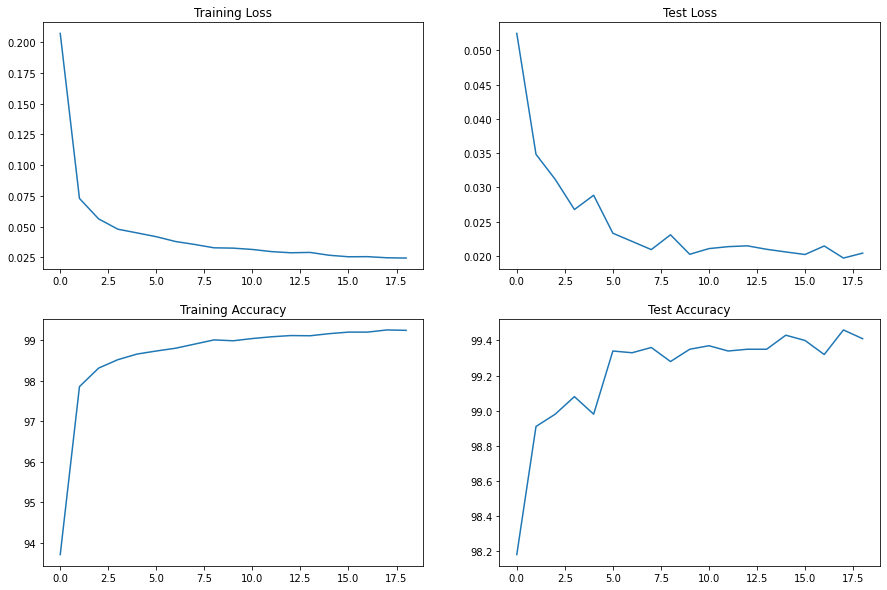

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")